In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

# %matplotlib notebook
%matplotlib inline

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import cached

from importlib import reload

reload(cached)

sim = cached.sim

In [3]:
def set_seed(i):
    random.seed(i)
    np.random.seed(random.getrandbits(32))

In [4]:
def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

compute 7 [1, 2, 3, 4, 5, 6, 7]


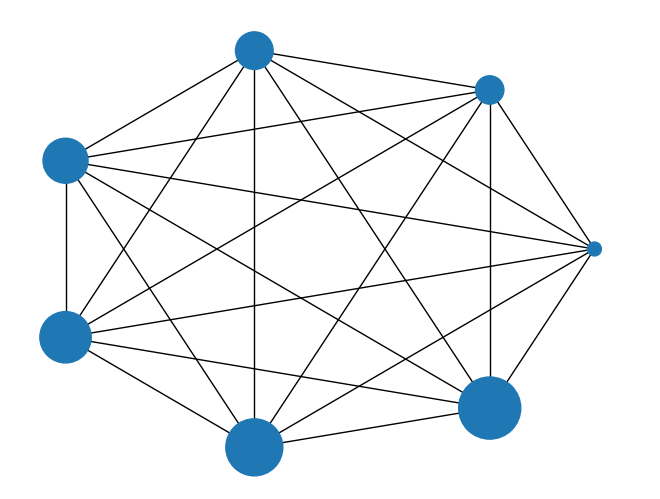

In [5]:
# Mining statistics for the last 7 days before Dec. 12 2022
# from https://www.blockchain.com/explorer/charts/pools
compute = [  # relative hash-rate # blocks mined / pool
    0.24817,  # 271 / Foundry USA
    0.20147,  # 220 / AntPool
    0.15110,  # 165 / F2Pool
    0.13736,  # 150 / Binance Pool
    0.10440,  # 114 / ViaBTC
    0.05311,  # 58  / Braiins Pool
    0.02473,  # 27  / Poolin
    0.01923,  # 21  / BTC.com
    0.01648,  # 18  / Luxor
    0.01465,  # 16  / Mara Pool
    0.00641,  # 7   / Ultimus
    0.00641,  # 7   / SBI Crypto
    0.00366,  # 4   / BTC M4
    0.00275,  # 3   / Titan
    # NaN    # 11  / Unknown
]
assert np.sum(compute) < 1
compute.append(1 - np.sum(compute))

compute = list(range(1, 8))

print("compute", len(compute), compute)

G = nx.complete_graph(len(compute))
G.graph["dissemination"] = "simple"

for i in range(len(compute)):
    G.nodes[i]["compute"] = compute[i]

for a, b in G.edges:
    # G.edges[a, b]["delay"] = f"uniform 0.5 1.5"
    G.edges[a, b]["delay"] = f"constant 1"

layout = nx.circular_layout(G)
draw(G, layout=layout)
# print_(G)

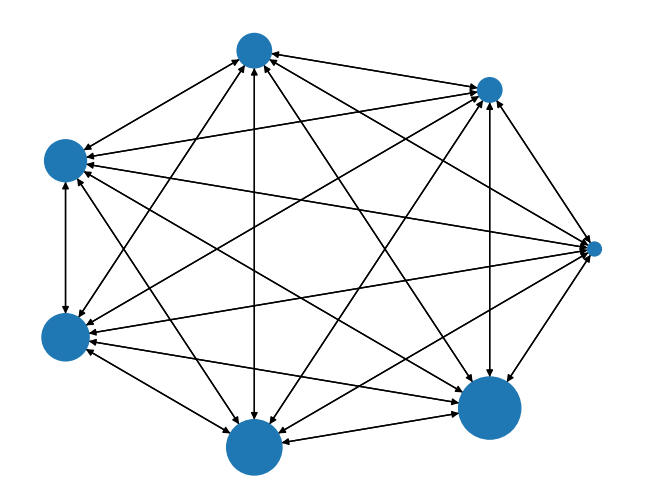

In [6]:
res = sim(G, activation_delay=1, activations=10000, protocol="nakamoto")
draw(res, size="reward", layout=layout)

In [7]:
# copied from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [8]:
families = dict(
    nakamoto=lambda x: "nakamoto",
    bk=lambda x: f"bk-{x.k}-constant",
    tailstorm=lambda x: f"tailstorm-{x.k}-{x.scheme}-heuristic",
)

ks = dict(
    nakamoto=[1],
    bk=[2, 4, 8, 16],
    tailstorm=[2, 4, 8, 16],
)

schemes = dict(
    nakamoto=["constant"], bk=["constant"], tailstorm=["constant", "discount"]
)

block_intervals = [
    1,
    2,
    4,
    8,
    16,
    32,
    64,
    128,
]  # nakamoto/tailstorm/bk blocks, tailstorm summaries (multiples of expected message delay)


def rows():
    for f in families.keys():
        for s in schemes[f]:
            for k in ks[f]:
                for bi in block_intervals:
                    for i in range(25):
                        ad = bi / k  # activation delay
                        if ad >= 1:
                            yield pd.Series(
                                dict(
                                    family=f,
                                    k=k,
                                    scheme=s,
                                    protocol=f"{f}-{k}-{s}",
                                    block_interval=bi,
                                    activation_delay=ad,
                                    seed=i,
                                )
                            )


def read(G, field):
    return np.array([G.nodes[i][field] for i in range(len(compute))])


def measure(x):
    res = sim(
        G,
        activation_delay=x.activation_delay,
        activations=8192,
        protocol=families[x.family](x),
        seed=x.seed,
    )
    reward = read(res, "reward")
    activations = read(res, "activations")
    compute = read(res, "compute")
    relrew = reward / np.sum(reward)
    relrewn = reward / np.sum(reward) / compute
    efficiency0 = reward / compute
    efficiency1 = reward / activations
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    return pd.Series(
        dict(
            revenue_loss=1 - (np.sum(reward) / np.sum(activations)),
            weakest_reward=reward[weakest],
            weakest_relrew=relrew[weakest],
            weakest_relrewn=relrewn[weakest],
            weakest_efficiency0=efficiency0[weakest],
            weakest_efficiency1=efficiency1[weakest],
            strongest_reward=reward[strongest],
            strongest_relrew=relrew[strongest],
            strongest_relrewn=relrewn[strongest],
            strongest_efficiency0=efficiency0[strongest],
            strongest_efficiency1=efficiency1[strongest],
            diff_reward=reward[strongest] - reward[weakest],
            diff_relrew=relrew[strongest] - relrew[weakest],
            diff_relrewn=relrewn[strongest] - relrewn[weakest],
            diff_efficiency0=efficiency0[strongest] - efficiency0[weakest],
            diff_efficiency1=efficiency1[strongest] - efficiency1[weakest],
            gini_reward=gini(reward),
            gini_relrew=gini(relrew),
            gini_relrewn=gini(relrewn),
            gini_efficiency0=gini(efficiency0),
            gini_efficiency1=gini(efficiency1),
        )
    )


df = pd.DataFrame(rows())
df = df.sample(frac=1)  # shuffle to distribute load more evenly among the threads
# df = pd.concat([df, df.apply(measure, axis=1)], axis=1)
df = pd.concat([df, df.parallel_apply(measure, axis=1)], axis=1)
df = df.sort_index()
df

,family,k,scheme,protocol,block_interval,activation_delay,seed,revenue_loss,weakest_reward,weakest_relrew,...,diff_reward,diff_relrew,diff_relrewn,diff_efficiency0,diff_efficiency1,gini_reward,gini_relrew,gini_relrewn,gini_efficiency0,gini_efficiency1
0,nakamoto,1,constant,nakamoto-1-constant,1,1.0,0,0.405640,114.0000,0.023413,...,1296.0000,0.266174,0.017956,87.428571,0.313995,0.347915,0.347915,0.096426,0.096426,0.100306
1,nakamoto,1,constant,nakamoto-1-constant,1,1.0,1,0.405640,130.0000,0.026700,...,1361.0000,0.279524,0.017047,83.000000,0.313790,0.360414,0.360414,0.094154,0.094154,0.097651
2,nakamoto,1,constant,nakamoto-1-constant,1,1.0,2,0.404419,101.0000,0.020701,...,1278.0000,0.261939,0.019676,96.000000,0.313687,0.353234,0.353234,0.112607,0.112607,0.108193
3,nakamoto,1,constant,nakamoto-1-constant,1,1.0,3,0.397827,135.0000,0.027367,...,1366.0000,0.276911,0.016101,79.428571,0.265102,0.363789,0.363789,0.102281,0.102281,0.100897
4,nakamoto,1,constant,nakamoto-1-constant,1,1.0,4,0.410767,111.0000,0.022996,...,1309.0000,0.271183,0.019030,91.857143,0.332597,0.366628,0.366628,0.115496,0.115496,0.119619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845,tailstorm,16,discount,tailstorm-16-discount,128,8.0,20,0.093384,269.0000,0.036219,...,1530.1875,0.206030,-0.001612,-11.973214,0.015452,0.279537,0.279537,0.012902,0.012902,0.002508
1846,tailstorm,16,discount,tailstorm-16-discount,128,8.0,21,0.088379,259.3125,0.034723,...,1513.2500,0.202631,-0.000815,-6.089286,0.007476,0.280444,0.280444,0.020626,0.020626,0.002040
1847,tailstorm,16,discount,tailstorm-16-discount,128,8.0,22,0.092651,265.0625,0.035660,...,1535.2500,0.206545,-0.001059,-7.875000,0.012392,0.281200,0.281200,0.011719,0.011719,0.003042
1848,tailstorm,16,discount,tailstorm-16-discount,128,8.0,23,0.090088,264.3750,0.035468,...,1621.5000,0.217534,0.000676,5.035714,0.008307,0.288599,0.288599,0.008183,0.008183,0.001789


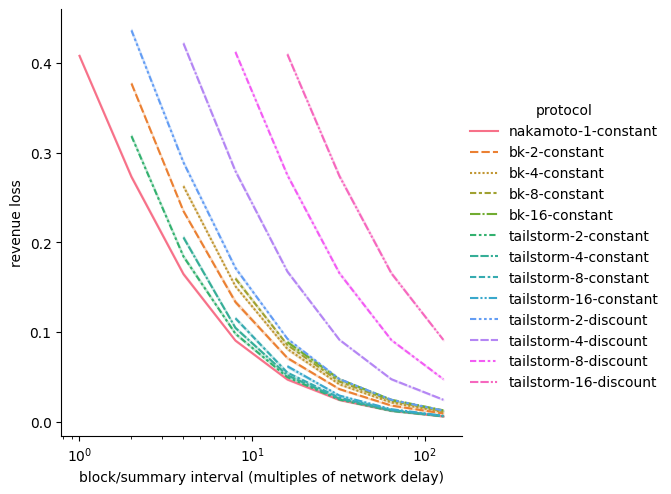

In [9]:
ax = sns.relplot(
    kind="line",
    data=df,
    hue="protocol",
    style="protocol",
    y="revenue_loss",
    x="block_interval",
    # col='k',
    # col_wrap=3,
)

ax.set(
    xscale="log",
    xlabel="block/summary interval (multiples of network delay)",
    ylabel="revenue loss",
)

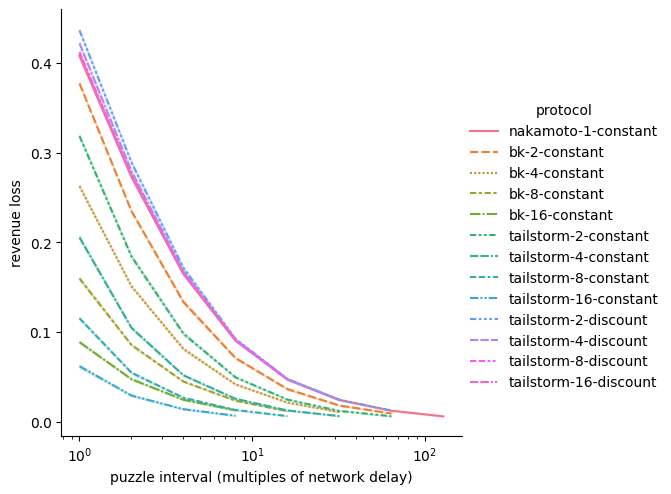

In [10]:
ax = sns.relplot(
    kind="line",
    data=df,
    hue="protocol",
    style="protocol",
    y="revenue_loss",
    x="activation_delay",
)

ax.set(
    xscale="log",
    xlabel="puzzle interval (multiples of network delay)",
    ylabel="revenue loss",
)

In [11]:
key = ["family", "k", "activation_delay", "block_interval"]
a = (
    df.query('scheme == "constant" and k in [1, 8]')
    .groupby(key)
    .agg(
        orphan_rate=("revenue_loss", np.mean),
        gini_constant=("gini_efficiency1", np.mean),
    )
)
b = (
    df.query('scheme != "constant" and k in [1, 8]')
    .groupby(key)
    .agg(
        revenue_loss=("revenue_loss", np.mean),
        gini_discount=("gini_efficiency1", np.mean),
    )
)
c = a.join(b)
for i, x in c.iterrows():
    if np.isnan(x.revenue_loss):
        c.loc[i]["revenue_loss"] = c.loc[i].orphan_rate
    if np.isnan(x.revenue_loss):
        c.loc[i]["revenue_loss"] = c.loc[i].orphan_rate
c.reset_index().sort_values(["block_interval", "family"])

,family,k,activation_delay,block_interval,orphan_rate,gini_constant,revenue_loss,gini_discount
5,nakamoto,1,1.0,1,0.407559,0.096532,0.407559,NaN
6,nakamoto,1,2.0,2,0.272979,0.047342,0.272979,NaN
7,nakamoto,1,4.0,4,0.164897,0.023132,0.164897,NaN
0,bk,8,1.0,8,0.159922,0.016514,0.159922,NaN
8,nakamoto,1,8.0,8,0.090933,0.011692,0.090933,NaN
13,tailstorm,8,1.0,8,0.115703,0.012804,0.411807,0.024396
1,bk,8,2.0,16,0.086055,0.008373,0.086055,NaN
9,nakamoto,1,16.0,16,0.047603,0.006653,0.047603,NaN
14,tailstorm,8,2.0,16,0.055195,0.006944,0.274878,0.011912
2,bk,8,4.0,32,0.045352,0.004955,0.045352,NaN


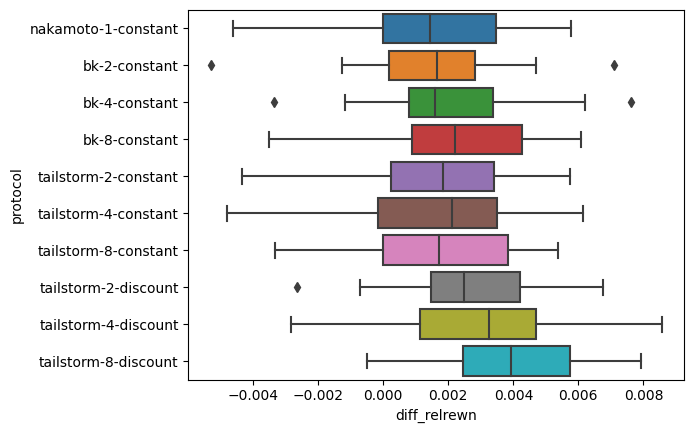

In [17]:
def bp(metric, bi=32, split="block_interval"):
    plt = sns.boxplot(
        data=df.query(f"block_interval == {bi}"),
        x=metric,
        y="protocol",
        orient="h",
    )


bp("diff_relrewn", bi=8)

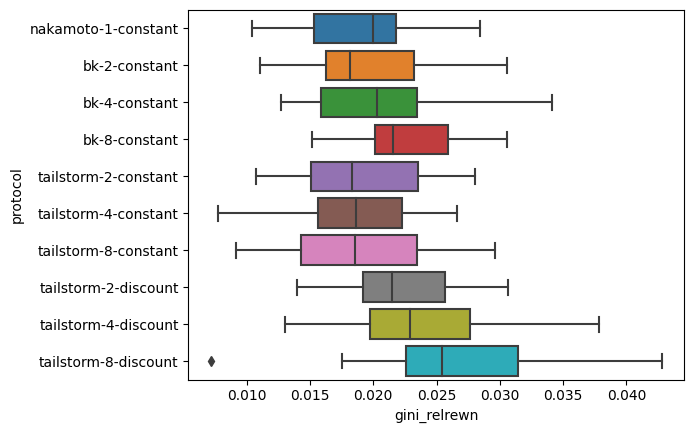

In [19]:
bp("gini_relrewn", bi=8)

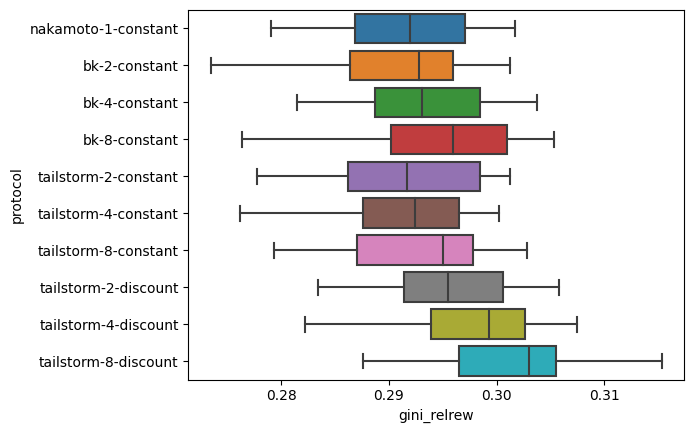

In [20]:
bp("gini_relrew", bi=8)

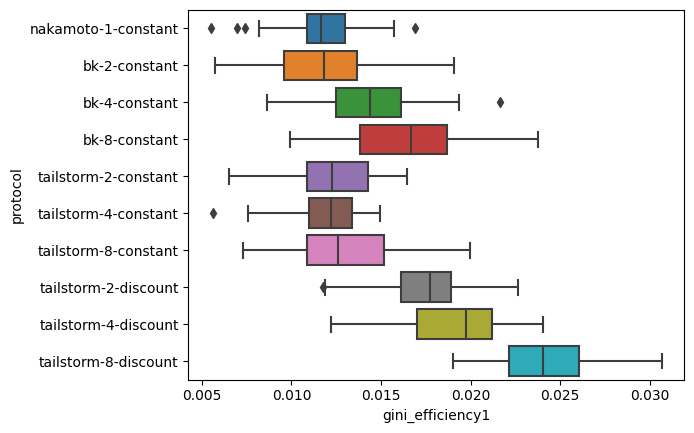

In [24]:
bp("gini_efficiency1", bi=8)